In [1]:
import pandas as pd
import numpy as np


from itertools import  combinations_with_replacement


import matplotlib.pyplot as plt

plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False


from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

# Load the data

In [2]:
# bodyId for oviINr
oviINr_id = 423101189

In [3]:
import pandas as pd

# load the modularity data for the oviINr inputs
mod = pd.read_csv('modularity_runs/0.0/0-0_98765.txt',header=None, sep=' ')
mod.columns = ['id', '0.0']

In [ ]:
# turn the id column into the index
mod.set_index('id', inplace=True)

In [5]:
# load the traced, non-cropped nodes from the hemibrain
HB_node_df = pd.read_csv("data/exported-traced-adjacencies-v1.2/traced-neurons.csv", index_col=0).fillna("None")
HB_node_df

,type,instance
bodyId,,
200326126,CL141,CL141_L
202916528,FS4C,FS4C(FQ12)_C4_R
203253072,FS4A,FS4A(AB)(FQ12)_C3_R
203253253,SMP505,SMP505(PDM22)_L
203257652,FS4C,FS4C(FQ12)_C6_R
...,...,...
7112579856,LC20,LC20
7112615127,AVLP335,AVLP335_R
7112617294,AVLP331,AVLP331_R


In [6]:
# must replace oviIN_nodes with the correct data.
valid_ovi_nodes = np.intersect1d(mod.index, HB_node_df.index)

# sort nodes by module id
valid_ovi_nodes = np.array(sorted(valid_ovi_nodes, key=lambda x: mod.loc[x, "0.0"]))

In [7]:
# load the traced, non-cropped edges from the hemibrain
HB_edge_df = pd.read_csv("data/exported-traced-adjacencies-v1.2/traced-total-connections.csv")  

In [8]:
# This cell takes ~ 15 seconds to work and takes up a lot of memory
HB_matrix = HB_edge_df.pivot_table(values="weight", index="bodyId_post", columns="bodyId_pre", fill_value=0.0)

# Correlation Coefficients of Inputs

Trying to compute the correlation coefficients of the input of each neuron. Also the similarity.

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


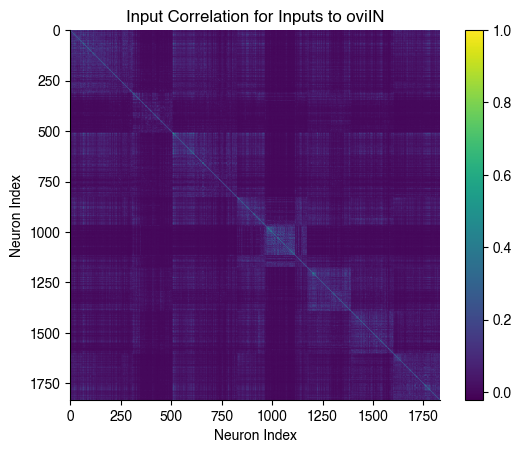

In [15]:
# gets the bodyId_post rows for the valid_ovi_nodes
X = HB_matrix.loc[valid_ovi_nodes].values

# get the correlation matrix
C = np.corrcoef(X)
plt.imshow(C)
plt.title("Input Correlation for Inputs to oviIN")
plt.xlabel("Neuron Index")
plt.ylabel("Neuron Index")
plt.colorbar()
# plt.xticks(range(len(valid_ovi_nodes)), valid_ovi_nodes, rotation="vertical")
plt.savefig(f"figures/input_correlation/all_input_correlation.pdf", bbox_inches="tight")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


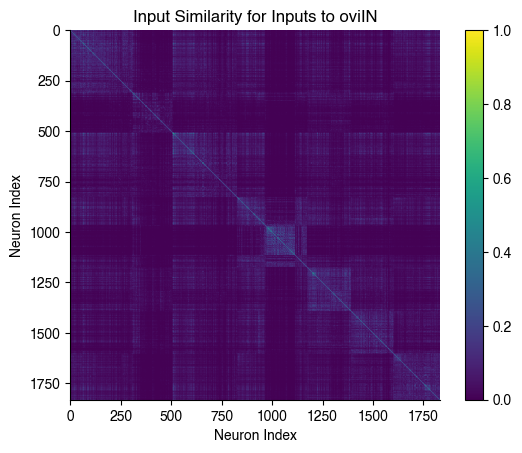

In [16]:
# get the similarity matrix
Xunit = X / np.sqrt(np.sum(X ** 2, axis=1))[:,None]
S = Xunit @ Xunit.T
plt.imshow(S)
plt.title("Input Similarity for Inputs to oviIN")
plt.xlabel("Neuron Index")
plt.ylabel("Neuron Index")
plt.colorbar()
plt.savefig(f"figures/input_correlation/all_input_similarity.pdf", bbox_inches="tight")

In [11]:
def corrDF_to_matrix(df, col1, col2, measure, stat):
    group_corrs = df.groupby([col1, col2]).agg({measure: stat})
    ngroups = df[col1].max()
    C = np.zeros((ngroups, ngroups))
    for i in range(ngroups):
        for j in range(i, ngroups):
            C[i,j] = C[j,i] = group_corrs.loc[(i+1, j+1), measure]
    return C

In [12]:
# shuffled data 
shuffled_df = mod.copy() #oviIN_nodes.loc[valid_ovi_nodes, ["0.0", "0.05", "0.1", "0.5", "0.75", "1.0", "instance", "celltype"]]
chis = ["0.0"]
n_trials = 100

for chi in chis:
    shuffles = np.zeros((len(shuffled_df), n_trials), dtype=int)
    for t in range(n_trials):
        shuffles[:, t] = shuffled_df[chi].values[np.random.permutation(len(shuffled_df))]
    tmp = pd.DataFrame(shuffles, index=shuffled_df.index, columns=[f"{chi}_s{t}" for t in range(n_trials)])
    shuffled_df = shuffled_df.merge(tmp, left_index=True, right_index=True)
shuffled_df

,0.0,0.0_s0,0.0_s1,0.0_s2,0.0_s3,0.0_s4,0.0_s5,0.0_s6,0.0_s7,0.0_s8,...,0.0_s90,0.0_s91,0.0_s92,0.0_s93,0.0_s94,0.0_s95,0.0_s96,0.0_s97,0.0_s98,0.0_s99
id,,,,,,,,,,,,,,,,,,,,,
1003215282,1,1,1,1,1,1,5,4,7,4,...,5,4,3,3,5,1,3,2,3,3
1005952640,2,4,1,7,1,7,4,7,5,6,...,5,3,2,4,3,6,1,5,2,3
1006928515,3,5,3,7,6,3,2,7,4,3,...,6,5,4,6,2,1,5,2,1,6
1007260806,3,4,4,5,1,7,5,6,5,1,...,3,2,2,1,2,6,6,4,6,3
1008024276,4,2,1,3,3,3,6,5,3,4,...,4,4,7,2,3,3,3,5,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987117151,2,6,7,3,3,4,7,2,3,1,...,3,5,7,1,1,7,5,3,2,4
987273073,6,3,1,4,4,1,5,1,7,1,...,7,2,7,6,6,5,5,3,6,3
988567837,5,2,2,4,3,1,3,4,4,1,...,7,3,4,4,2,1,2,6,4,3


In [13]:
corr_df = pd.DataFrame([[valid_ovi_nodes[i], valid_ovi_nodes[j], C[i,j], S[i,j]] for (i,j) in combinations_with_replacement(range(len(valid_ovi_nodes)), 2)],
                       columns=["bodyId1", "bodyId2", "correlation", "similarity"])

# corr_df = corr_df.merge(oviIN_nodes["0.0"], left_on="bodyId1", right_index=True)
# corr_df = corr_df.merge(oviIN_nodes["0.0"], left_on="bodyId2", right_index=True, suffixes=["_1","_2"])
corr_df = corr_df.merge(shuffled_df, left_on="bodyId1", right_index=True)
corr_df = corr_df.merge(shuffled_df, left_on="bodyId2", right_index=True, suffixes=["_1", "_2"])
corr_df

,bodyId1,bodyId2,correlation,similarity,0.0_1,0.0_s0_1,0.0_s1_1,0.0_s2_1,0.0_s3_1,0.0_s4_1,...,0.0_s90_2,0.0_s91_2,0.0_s92_2,0.0_s93_2,0.0_s94_2,0.0_s95_2,0.0_s96_2,0.0_s97_2,0.0_s98_2,0.0_s99_2
0,267551639,267551639,1.000000,1.000000,1,3,5,4,1,4,...,4,4,1,2,4,4,7,4,5,4
1,267551639,297563139,0.162749,0.165905,1,3,5,4,1,4,...,4,4,2,1,5,2,1,4,6,7
2,267551639,299290105,0.208832,0.212979,1,3,5,4,1,4,...,5,3,5,7,3,1,5,1,3,2
3,267551639,326253554,0.034535,0.040025,1,3,5,4,1,4,...,1,5,5,7,5,2,3,1,7,7
4,267551639,327587644,0.147711,0.152833,1,3,5,4,1,4,...,3,2,5,3,3,4,1,3,6,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1679023,5901203505,5901221890,0.081569,0.085378,7,3,5,4,1,1,...,6,5,1,4,5,5,4,3,4,1
1679024,5901203505,6400000773,0.016982,0.020159,7,3,5,4,1,1,...,4,3,4,4,4,3,4,7,1,3
1679025,5901221890,5901221890,1.000000,1.000000,7,2,1,3,4,3,...,6,5,1,4,5,5,4,3,4,1
1679026,5901221890,6400000773,0.043026,0.046729,7,2,1,3,4,3,...,4,3,4,4,4,3,4,7,1,3


In [14]:
valid_corrs = corr_df[corr_df.bodyId1 != corr_df.bodyId2]

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


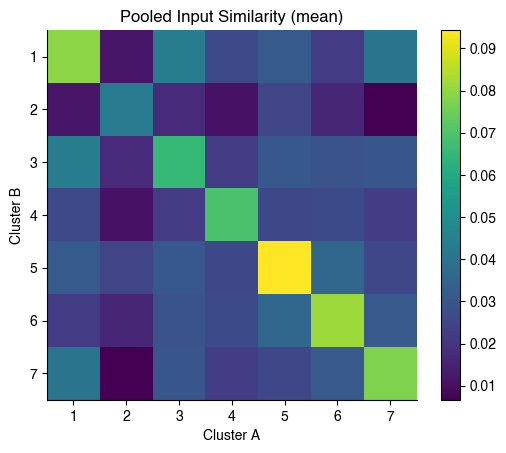

In [23]:
# pooled similarity
measure = "similarity"
stat = "mean"

n_clusters = mod['0.0'].max()
CC = np.zeros((n_clusters,n_clusters))
CC = corrDF_to_matrix(valid_corrs, "0.0_1", "0.0_2", measure, stat)

plt.imshow(CC)
plt.title(f"Pooled Input {measure.capitalize()} ({stat})")
plt.xticks(range(n_clusters), range(1,n_clusters+1))
plt.yticks(range(n_clusters), range(1,n_clusters+1))
plt.xlabel("Cluster A")
plt.ylabel("Cluster B")
plt.colorbar()

plt.savefig(f"figures/input_correlation/pooled_input_similarity.pdf", bbox_inches="tight")

In [18]:
# true_corrs = valid_corrs.groupby(["0.0_1", "0.0_2"]).agg({"correlation": ["median", "mean", "std"], "similarity": ["median", "mean", "std"]})
cluster_corrs = valid_corrs.groupby(["0.0_1", "0.0_2"]).agg({"correlation": ["median", "mean", "std"], "similarity": ["median", "mean", "std"]})
cluster_corrs

correlation                     similarity                    
                 median      mean       std     median      mean       std
0.0_1 0.0_2                                                               
1     1        0.039250  0.076498  0.103468   0.042112  0.079118  0.103149
      2       -0.000580  0.009330  0.030785   0.001765  0.011923  0.030890
      3        0.016026  0.040528  0.064366   0.019308  0.043552  0.064194
      4        0.001812  0.022556  0.056669   0.005290  0.025970  0.056350
      5        0.008427  0.028490  0.056110   0.011841  0.031645  0.055938
      6        0.003550  0.019294  0.046488   0.006705  0.022407  0.046308
      7        0.013742  0.037647  0.064348   0.016914  0.040577  0.064110
2     2        0.008683  0.040320  0.089442   0.011146  0.042622  0.089302
      3        0.001712  0.014605  0.036021   0.004453  0.017463  0.036159
      4       -0.001509  0.007746  0.032610   0.001116  0.010929  0.032655
      5        0.005507  0.022179  0.042276   0.008421  0.025092  0.042420
      6       -0.000080  0.013178  0.038013   0.002620  0.016057  0.038037
      7       -0.001462  0.003900  0.021687   0.000413  0.006695  0.021778
3     3        0.029683  0.062195  0.090324   0.033205  0.065465  0.090093
      4        0.000014  0.018039  0.048977   0.003868  0.021842  0.048742
      5        0.009959  0.027382  0.050030   0.013550  0.030884  0.049942
      6        0.006196  0.025613  0.051152   0.009596  0.029039  0.051036
      7        0.006216  0.026814  0.052388   0.009718  0.030100  0.052254
4     4        0.022304  0.065226  0.104270   0.026462  0.069190  0.103988
      5        0.003101  0.021949  0.049582   0.007044  0.025833  0.049508
      6        0.003834  0.022445  0.049016   0.007625  0.026237  0.048898
      7        0.001552  0.018827  0.045888   0.005222  0.022490  0.045689
5     5        0.063271  0.090992  0.093507   0.066957  0.094327  0.093354
      6        0.014866  0.032265  0.050437   0.018391  0.035756  0.050409
      7        0.005497  0.021963  0.046985   0.008951  0.025360  0.046879
6     6        0.046220  0.078321  0.097668   0.049462  0.081537  0.097473
      7        0.008633  0.027778  0.052954   0.012055  0.031066  0.052915
7     7        0.041665  0.074221  0.098292   0.044989  0.077218  0.097981

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


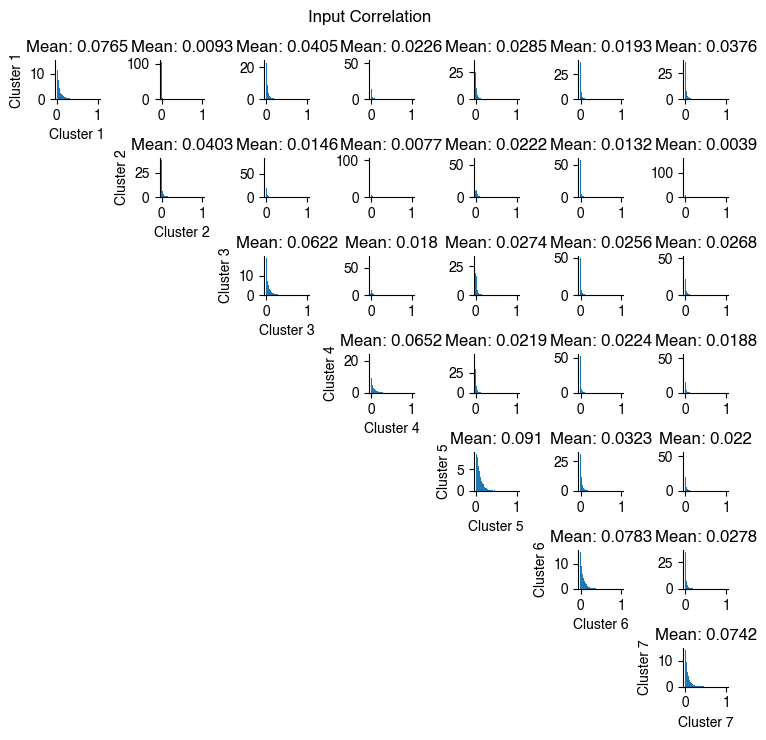

In [19]:
eps = 0.05
measure = "correlation"
stat = "mean"
plt.figure(tight_layout="tight",
           figsize=(7.5, 7.5))
plt.suptitle(f"Input {measure.capitalize()}")
for i in range(n_clusters):
    for j in range(i,n_clusters):
        plt.subplot(n_clusters,n_clusters,i*n_clusters + j + 1)
        plt.hist(valid_corrs[(valid_corrs["0.0_1"] == (i+1)) & (valid_corrs["0.0_2"] == (j+1))][measure],
                 bins=100, density=True)
        # plt.axvline(cluster_corrs.loc[(i+1, j+1), (measure, stat)], color="red")
        plt.xlim(-eps, 1 + eps)
        plt.title(f"{stat.capitalize()}: {round(cluster_corrs.loc[(i+1, j+1), (measure, stat)], 4)}")
        if j == i:
            plt.xlabel(f"Cluster {i+1}")
            plt.ylabel(f"Cluster {j+1}")

plt.savefig(f"figures/input_correlation/oviIN_input_connectome_input_{measure}.pdf", bbox_inches="tight")

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


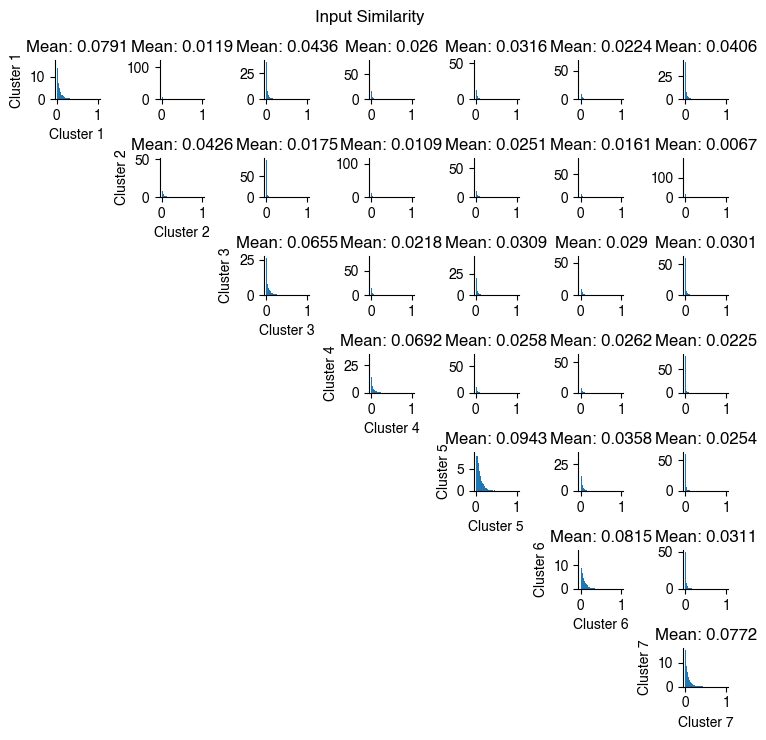

In [22]:
eps = 0.05
measure = "similarity"
stat = "mean"
plt.figure(tight_layout="tight",
           figsize=(7.5, 7.5))
plt.suptitle(f"Input {measure.capitalize()}")
for i in range(n_clusters):
    for j in range(i,n_clusters):
        plt.subplot(n_clusters,n_clusters,i*n_clusters + j + 1)
        plt.hist(valid_corrs[(valid_corrs["0.0_1"] == (i+1)) & (valid_corrs["0.0_2"] == (j+1))][measure],
                 bins=100, density=True)
        # plt.axvline(cluster_corrs.loc[(i+1, j+1), (measure, stat)], color="red")
        plt.xlim(-eps, 1 + eps)
        plt.title(f"{stat.capitalize()}: {round(cluster_corrs.loc[(i+1, j+1), (measure, stat)], 4)}")
        if j == i:
            plt.xlabel(f"Cluster {i+1}")
            plt.ylabel(f"Cluster {j+1}")

plt.savefig(f"figures/input_correlation/oviIN_input_connectome_input_{measure}.pdf", bbox_inches="tight")

In [20]:
n_trials = 100
lots_of_C = np.zeros((n_trials, n_clusters, n_clusters))
for t in range(n_trials):
    lots_of_C[t, :, :] = corrDF_to_matrix(valid_corrs, f"0.0_s{t}_1", f"0.0_s{t}_2", measure, stat)

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


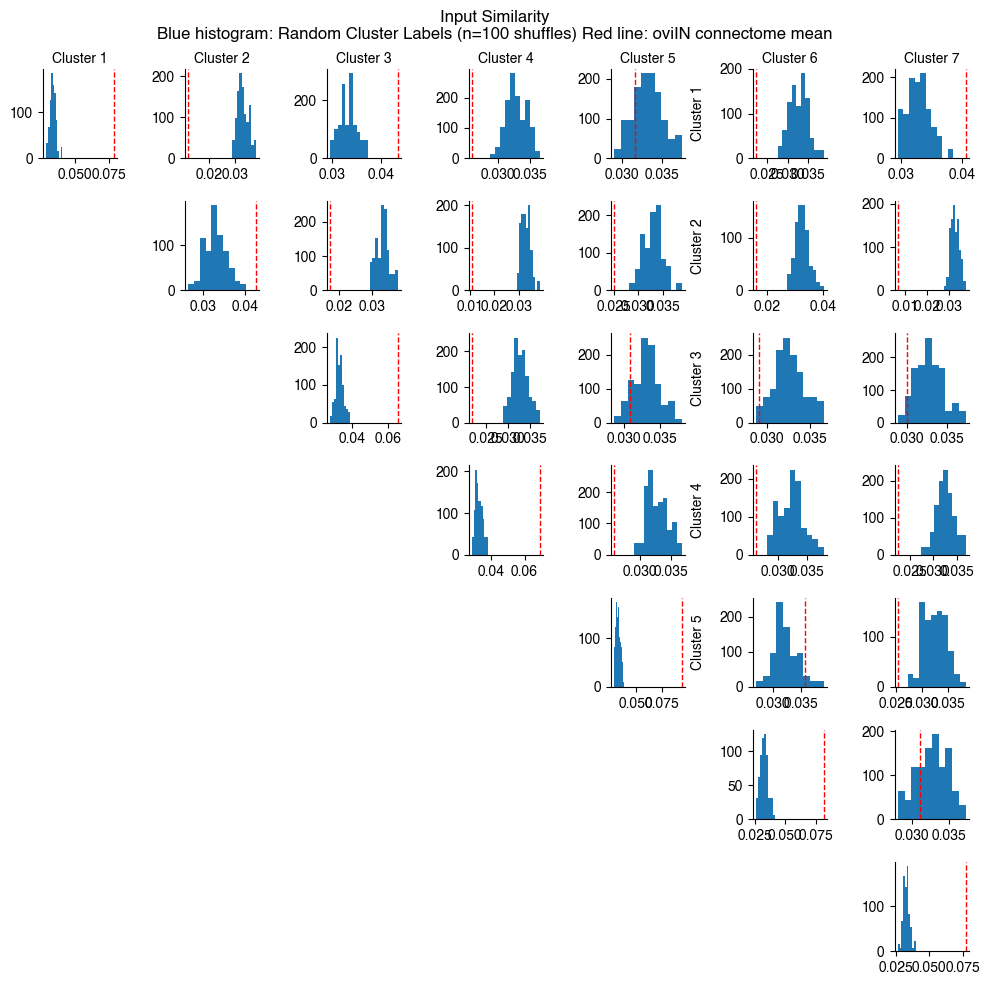

In [21]:
eps = 0.05
measure = "similarity"
stat = "mean"

lots_of_C = np.zeros((n_trials, n_clusters, n_clusters))
for t in range(n_trials):
    lots_of_C[t, :, :] = corrDF_to_matrix(valid_corrs, f"0.0_s{t}_1", f"0.0_s{t}_2", measure, stat)

plt.figure(tight_layout="tight",
           figsize=(10,10))
plt.suptitle(f"Input {measure.capitalize()}\nBlue histogram: Random Cluster Labels (n={n_trials} shuffles)\tRed line: oviIN connectome {stat}")
for i in range(n_clusters):
    for j in range(i,n_clusters):
        plt.subplot(n_clusters,n_clusters,i*n_clusters + j + 1)
        plt.axvline(CC[i, j], color="red", linewidth=1, linestyle="dashed")
        plt.hist(lots_of_C[:, i, j], bins=10, density=True)
        if i == 0:
            plt.gca().xaxis.set_label_position("top")
            plt.xlabel(f"Cluster {j+1}")
            # plt.title(f"Cluster {j+1}")
        if j == 4:
            plt.gca().yaxis.set_label_position("right")
            plt.ylabel(f"Cluster {i+1}")

plt.savefig(f"figures/input_correlation/comparison_to_shuffle_{measure}.pdf")